In [16]:
# Copyright (c) 2025, ETH Zurich

In [ ]:
import os
import pathlib
import datetime

In [17]:
# This cell is tagged `parameters`
system = "<System_Name_Same_as_Folder_Name>"
sample_size_cm = 6
storage = "<Path_to_System_Folder>
binning = 1
nslices = 21

# Initialization

In [3]:
%matplotlib inline

In [4]:
import glob
import os

import numpy as np
import scipy
import scipy.constants as cnst
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage as ski
import xarray as xr
import tomopy
import astra

import sys
import spekpy as sp

import skimage
from scipy import interpolate
import skimage.io as io
import xraydb
import utils.icru44data as icru44data

import xraydb
import json
from filelock import FileLock

In [5]:
# matplotlib style
plt.style.use("default")

# set FIGWIDTH to latex's \textwidth
FIGWIDTH = 3
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 5
plt.rcParams["figure.figsize"] = (FIGWIDTH, FIGWIDTH * 2 / 3)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = "True"

# images
plt.rcParams["image.interpolation"] = "bicubic"
plt.rcParams["image.cmap"] = "Greys_r"

# axes
# plt.rcParams["axes.spines.right"] = False
# plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.edgecolor"] = "0.7"
plt.rcParams["axes.linewidth"] = "1"

# legend
plt.rcParams["legend.frameon"] = False

plt.rcParams["lines.markersize"] = 1
# plt.rcParams["lines.markerfacecolor"] = "white"
# Okabe-Ito palette
plt.rcParams["axes.prop_cycle"] = plt.cycler(
    color=[
        "#000000",
        "#E69F00",
        "#56B4E9",
        "#009E73",
        "#F0E442",
        "#0072B2",
        "#D55E00",
        "#CC79A7",
    ],
    #marker=None #["o", "^", "s", "p", "D", "v", "v", "d"],
)

plt.rcParams['axes.grid'] = False

# Funtionalities for CNR calculation

In [23]:
def get_mask_span(m):
    x0 = m.any(axis=0).nonzero()[0][0]
    x1 = m.any(axis=0).nonzero()[0][-1]
    y0 = m.any(axis=1).nonzero()[0][0]
    y1 = m.any(axis=1).nonzero()[0][-1]

    #print(x0, x1, y0, y1)
    return y0, y1, x0, x1

def get_mask_sel(m, margin=0):
    y0, y1, x0, x1 = get_mask_span(m)

    return np.s_[..., (y0 - margin) : (y1 + margin + 1), (x0 - margin) : (x1 + margin + 1)]


def get_mask_sel_norm(m, margin=0):
    y0, y1, x0, x1 = get_mask_span(m)

    return np.s_[(nslices // 2 - nslices // 4) : (nslices // 2 + nslices // 4) , (y0 - margin) : (y1 + margin + 1), (x0 - margin) : (x1 + margin + 1)]

idx_row = nslices // 2

### Functions for image fusion
def normalise(d, m1, m2, ref):
    s1 = get_mask_sel_norm(m1, margin=0)
    s2 = get_mask_sel_norm(m2, margin=0)

    v1 = ref[:][s1].mean()
    v2 = ref[:][s2].mean()

    return (d - v1) / (v2 - v1)

def fuse(d1, d2, sigma):
    d1f = scipy.ndimage.gaussian_filter(d1, sigma=[0, sigma, sigma])
    d2f = d2 - scipy.ndimage.gaussian_filter(d2, sigma=[0, sigma, sigma])

    return d1f + d2f

def get_area_roi(sample_size_cm, system = 'GI-BCT_V2'):
    global voxel_size
    global vmin_abs
    global vmax_abs
    global vmin_ref
    global vmax_ref
    
    phantom = io.imread(os.path.join(storage, f"{system}_tumor/{system}_{sample_size_cm}_phantom.tif"))
    if 'GI-BCT_V2' in system:
        voxel_size = 62.141479456616764 * 1e-4 * binning
        vmin_abs = -1
        vmax_abs = 2
        vmin_ref = -1
        vmax_ref = 2
        
    elif 'Static' in system:
        voxel_size = 58.6405529953917 * 1e-4 * binning
        vmin_abs = -1
        vmax_abs = 2
        vmin_ref = -1
        vmax_ref = 2
        
    elif 'Gantry' in system:
        voxel_size = 49.64559192553947 * 1e-4 * binning
        vmin_abs = -1
        vmax_abs = 2
        vmin_ref = -1
        vmax_ref = 2
    
        
    elif 'nuview' in system:
        voxel_size = 76.92307692307692 * 1e-4 * binning
    
    radius_disk = 0.046 * sample_size_cm
    radius_disk = np.floor(radius_disk / voxel_size)

    fibroglandular_center = (phantom.shape[0] * 0.6, phantom.shape[1] * 0.7)

    rr, cc = skimage.draw.disk((fibroglandular_center[1], fibroglandular_center[0]), radius = radius_disk, shape=phantom.shape)
    fibro_circle = np.zeros_like(phantom, dtype=np.int8)
    fibro_circle[rr, cc] = 1

    adipose_center = (phantom.shape[0] * 0.42, phantom.shape[1] * 0.2)

    rr, cc = skimage.draw.disk((adipose_center[1], adipose_center[0]), radius = radius_disk, shape=phantom.shape)
    adi_circle = np.zeros_like(phantom, dtype=np.int8)
    adi_circle[rr, cc] = 1

    tumor_center = (phantom.shape[0] * 0.54, phantom.shape[1] * 0.46)

    rr, cc = skimage.draw.disk((tumor_center[1], tumor_center[0]), radius = radius_disk, shape=phantom.shape)
    tumor_circle = np.zeros_like(phantom, dtype=np.int8)
    tumor_circle[rr, cc] = 1
    
    return fibro_circle, adi_circle, tumor_circle, phantom

def update_json(file_path, key, values):
    """Load, update, and save the JSON file."""
    # Load existing data or initialize as an empty dictionary
    try:
        with open(file_path, "r") as file:
            data = json.load(file)
    except (FileNotFoundError, json.JSONDecodeError):
        data = {}

    # Update the dictionary
    data[key] = values

    # Write updated data back to the JSON file
    with open(file_path, "w") as file:
        json.dump(data, file, indent=4)
        
def write_to_json(file_path, sample_size, result):
    # Lock file to prevent concurrent writes
    lock = FileLock(f"{file_path}.lock")
    with lock:
        # Load existing data or initialize as an empty dictionary
        try:
            with open(file_path, "r") as file:
                data = json.load(file)
        except (FileNotFoundError, json.JSONDecodeError):
            data = {}

        # Update the data with the new result
        data[sample_size] = result

        # Write the updated data back to the file
        with open(file_path, "w") as file:
            json.dump(data, file, indent=4)
            

# CNR Calculation

In [7]:
fibro_circle, adi_circle, tumor_circle, phantom = get_area_roi(sample_size_cm, system)

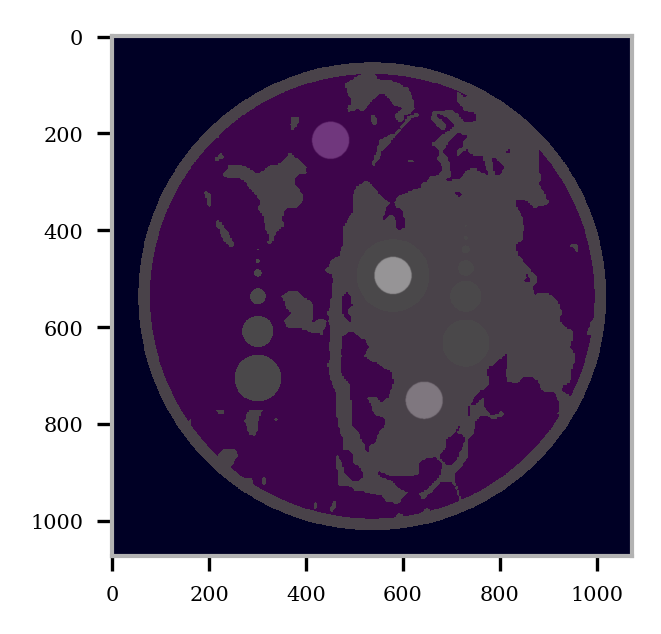

In [8]:
plt.imshow(phantom,  cmap = 'gist_ncar', interpolation = 'none')
plt.imshow(adi_circle, alpha = 0.4)
plt.imshow(fibro_circle, alpha = 0.3)
plt.imshow(tumor_circle, alpha = 0.3)



In [33]:
doses = np.array([2,3,4,5,6,7,10,15,20,25,30,40,50,60,70,80,90,100])
features_radius_mm = np.array([3, 2, 1, 0.5, 0.25, 0.1])

In [10]:
d = 90
attenuation = io.imread(os.path.join(storage, f"{system}_tumor/{system}_tumor_{sample_size_cm}_absorption_{d}mGy.tif"))


In [12]:
voxel_size

0.006214147945661676

In [13]:

def get_filtered_roi(d, mask, sigma):
    margin = 1
    s = get_mask_sel(mask, margin=margin)
    ds = d.astype(np.float32)[s]
    df = scipy.ndimage.gaussian_filter(ds[nslices//2-nslices//4:nslices//2+nslices//4,...], sigma=[sigma, sigma, sigma])
    dfs = df[df.shape[0] // 2, margin : -margin, margin : -margin]
    return dfs[mask[get_mask_sel(mask)]==1]

def get_cnr(d, m1, m2, sigma):
    dgland = get_filtered_roi(d, m1, sigma)
    dadipose = get_filtered_roi(d, m2, sigma)
    #print(dgland.shape)
    #print(dadipose.shape)
    #print('gland:', dgland.mean())
    #print('adipose', dadipose.mean())
    contrast = np.abs(dgland.mean() - dadipose.mean())
    noise = np.sqrt((dgland.std()**2 + dadipose.std()**2) / 2)

    return contrast / noise

# Fibro vs Adipose

In [25]:
target_cnr = 5


print(f"Starting with size: {sample_size_cm}cm")
sigmas_att = []

fibro_circle, adi_circle, tumor_circle, phantom = get_area_roi(sample_size_cm, system)


for d in doses:
    #print(f"Finding the kernel size for a dose of {d}mGy...", end="")
    attenuation = io.imread(os.path.join(storage, f"{system}_tumor/{system}_tumor_{sample_size_cm}_absorption_{d}mGy.tif"))

    try:
        s = scipy.optimize.bisect(lambda sigma: get_cnr(attenuation, fibro_circle, adi_circle, sigma) - target_cnr, 0, 15)
        sigmas_att.append(s)
    except:
        sigmas_att.append(0)




write_to_json(os.path.join(storage, f"{system}_tumor/{system}_attenuation_FA_L.json"), sample_size_cm, sigmas_att)

Starting with size: 6cm


In [28]:
linestyles = ['-', '--', '-.', ':']

In [29]:
colors = ["C0", "C1", "C2", "C3", "C4", "C5","C6", 'C7', "C8", "C9"]
linestyles = ['-', '--', '-.', ':', '-', '--']

/usr/terminus/data-xrm-01/stamplab/users/vieirapa/micromamba/envs/pcpy/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/terminus/data-xrm-01/stamplab/users/vieirapa/micromamba/envs/pcpy/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/terminus/data-xrm-01/stamplab/users/vieirapa/micromamba/envs/pcpy/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


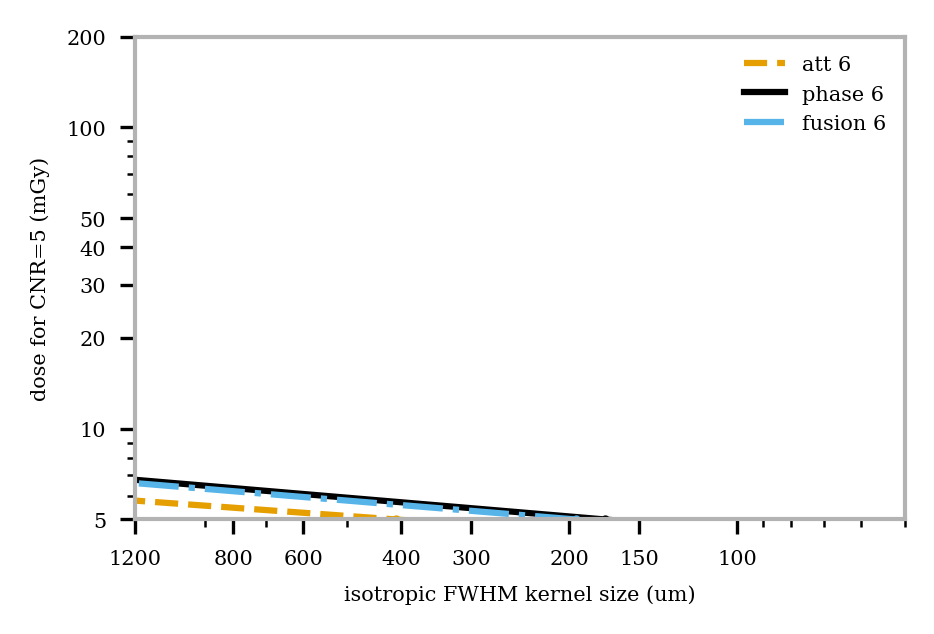

In [35]:


fwhm_att = np.r_[sigmas_att] * 2.355 * voxel_size *1e4


aatt, batt = np.polyfit(np.log(fwhm_att[fwhm_att > 0]), np.log(doses[fwhm_att > 0]), 1)


x = np.linspace(50, 1200)

plt.plot(x, np.exp(batt) * x**aatt, color = colors[1], linestyle=linestyles[1], label=f"att {sample_size_cm}")
#plt.plot(x, 0.5 * np.exp(batt) * x**aatt, color="C0", ls="--", lw=0.8)



plt.plot(fwhm_att, doses, "o", color=colors[1])

#plt.axvspan(150, 300, color="0.9")

plt.xscale("log")
plt.yscale("log")
plt.gca().invert_xaxis()
plt.xlim(1200, 50)
plt.ylim(5, 200)
plt.xticks([1200, 800, 600, 400, 300, 200, 150, 100], map(str, [1200, 800, 600, 400, 300, 200, 150, 100]))
plt.yticks([5, 10, 20, 30, 40, 50, 100, 200], map(str, [5, 10, 20, 30, 40, 50, 100, 200]))
plt.xlabel("isotropic FWHM kernel size (um)")
plt.ylabel(f"dose for CNR={target_cnr} (mGy)")
plt.legend()

# Tumor vs Fibrogland

In [41]:
target_cnr = 5


print(f"Starting with size: {sample_size_cm}cm")
sigmas_att = []

fibro_circle, adi_circle, tumor_circle, phantom = get_area_roi(sample_size_cm, system)




for d in doses:
    #print(f"Finding the kernel size for a dose of {d}mGy...", end="")
    attenuation = io.imread(os.path.join(storage, f"{system}_tumor/{system}_tumor_{sample_size_cm}_absorption_{d}mGy.tif"))

    try:
        s = scipy.optimize.bisect(lambda sigma: get_cnr(attenuation, tumor_circle, fibro_circle, sigma) - target_cnr, 0, 25)
        sigmas_att.append(s)
    except: 
        sigmas_att.append(0)

write_to_json(os.path.join(storage, f"{system}_tumor/{system}_attenuation_TF_L.json"), sample_size_cm, sigmas_att)



Starting with size: 6cm


/usr/terminus/data-xrm-01/stamplab/users/vieirapa/micromamba/envs/pcpy/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/terminus/data-xrm-01/stamplab/users/vieirapa/micromamba/envs/pcpy/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/terminus/data-xrm-01/stamplab/users/vieirapa/micromamba/envs/pcpy/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


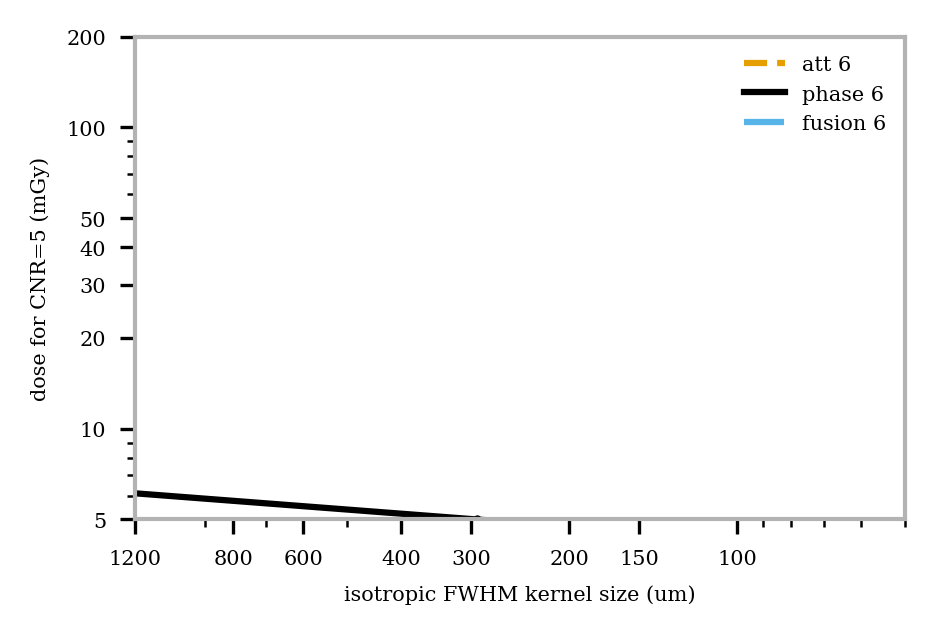

In [66]:


fwhm_att = np.r_[sigmas_att] * 2.355 * voxel_size *1e4


aatt, batt = np.polyfit(np.log(fwhm_att[fwhm_att > 0]), np.log(doses[fwhm_att > 0]), 1)


x = np.linspace(50, 1200)

plt.plot(x, np.exp(batt) * x**aatt, color = colors[1], linestyle=linestyles[1], label=f"att {sample_size_cm}")
#plt.plot(x, 0.5 * np.exp(batt) * x**aatt, color="C0", ls="--", lw=0.8)



plt.plot(fwhm_att, doses, "o", color=colors[1])


#plt.axvspan(150, 300, color="0.9")

plt.xscale("log")
plt.yscale("log")
plt.gca().invert_xaxis()
plt.xlim(1200, 50)
plt.ylim(5, 200)
plt.xticks([1200, 800, 600, 400, 300, 200, 150, 100], map(str, [1200, 800, 600, 400, 300, 200, 150, 100]))
plt.yticks([5, 10, 20, 30, 40, 50, 100, 200], map(str, [5, 10, 20, 30, 40, 50, 100, 200]))
plt.xlabel("isotropic FWHM kernel size (um)")
plt.ylabel(f"dose for CNR={target_cnr} (mGy)")
plt.legend()

# Tumor vs Adipose

In [68]:
target_cnr = 5


print(f"Starting with size: {sample_size_cm}cm")
sigmas_att = []

fibro_circle, adi_circle, tumor_circle, phantom = get_area_roi(sample_size_cm, system)


for d in doses:
    #print(f"Finding the kernel size for a dose of {d}mGy...", end="")
    attenuation = io.imread(os.path.join(storage, f"{system}_tumor/{system}_tumor_{sample_size_cm}_absorption_{d}mGy.tif"))

    try:
        s = scipy.optimize.bisect(lambda sigma: get_cnr(attenuation, tumor_circle, adi_circle, sigma) - target_cnr, 0, 25)
        sigmas_att.append(s)
    except: 
        sigmas_att.append(0)




write_to_json(os.path.join(storage, f"{system}_tumor/{system}_attenuation_TA_L.json"), sample_size_cm, sigmas_att)



Starting with size: 6cm


/usr/terminus/data-xrm-01/stamplab/users/vieirapa/micromamba/envs/pcpy/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/terminus/data-xrm-01/stamplab/users/vieirapa/micromamba/envs/pcpy/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/terminus/data-xrm-01/stamplab/users/vieirapa/micromamba/envs/pcpy/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


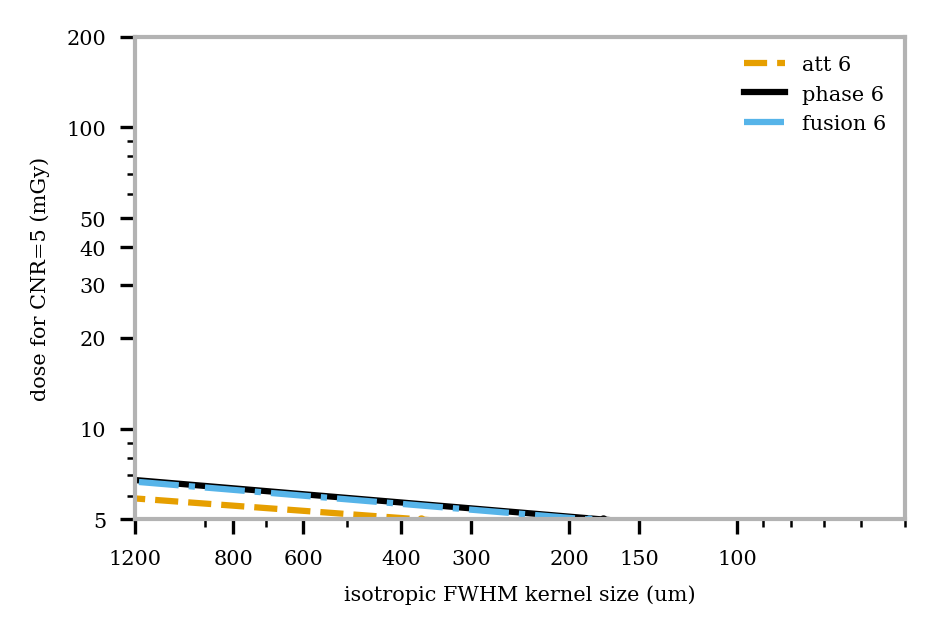

In [70]:


fwhm_att = np.r_[sigmas_att] * 2.355 * voxel_size *1e4


aatt, batt = np.polyfit(np.log(fwhm_att[fwhm_att > 0]), np.log(doses[fwhm_att > 0]), 1)


x = np.linspace(50, 1200)

plt.plot(x, np.exp(batt) * x**aatt, color = colors[1], linestyle=linestyles[1], label=f"att {sample_size_cm}")
#plt.plot(x, 0.5 * np.exp(batt) * x**aatt, color="C0", ls="--", lw=0.8)



plt.plot(fwhm_att, doses, "o", color=colors[1])

#plt.axvspan(150, 300, color="0.9")

plt.xscale("log")
plt.yscale("log")
plt.gca().invert_xaxis()
plt.xlim(1200, 50)
plt.ylim(5, 200)
plt.xticks([1200, 800, 600, 400, 300, 200, 150, 100], map(str, [1200, 800, 600, 400, 300, 200, 150, 100]))
plt.yticks([5, 10, 20, 30, 40, 50, 100, 200], map(str, [5, 10, 20, 30, 40, 50, 100, 200]))
plt.xlabel("isotropic FWHM kernel size (um)")
plt.ylabel(f"dose for CNR={target_cnr} (mGy)")
plt.legend()